# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

 **Pytorch Version** 

* [1. Task Description](#0)
* [2. Install Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. A List of Python Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download and Preprocess Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5. Build Market Environment in OpenAI Gym-style](#4)  
    * [5.1. Data Split](#4.1)  
    * [5.3. Environment for Training](#4.2)    
* [6. Train DRL Agents](#5)
* [7. Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   

# Part 1. Task Discription

We train a DRL agent for stock trading. This task is modeled as a Markov Decision Process (MDP), and the objective function is maximizing (expected) cumulative return.

We specify the state-action-reward as follows:

* **State s**: The state space represents an agent's perception of the market environment. Just like a human trader analyzing various information, here our agent passively observes many features and learns by interacting with the market environment (usually by replaying historical data).

* **Action a**: The action space includes allowed actions that an agent can take at each state. For example, a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying. When an action operates multiple shares, a ∈{−k, ..., −1, 0, 1, ..., k}, e.g.. "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* **Reward function r(s, a, s′)**: Reward is an incentive for an agent to learn a better policy. For example, it can be the change of the portfolio value when taking a at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio values at state s′ and s, respectively


**Market environment**: 30 consituent stocks of Dow Jones Industrial Average (DJIA) index. Accessed at the starting date of the testing period.


The data for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.

# Part 2. Install Python Packages

## 2.1. Install packages

In [ ]:
## install finrl library
# 已安装，暂不用执行
# !pip install wrds
# !pip install swig
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

## 2.2. A list of Python packages 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

## 2.3. Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime

%matplotlib inline
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor

from finrl.plot import backtest_stats,backtest_plot,get_daily_return,get_baseline
from pprint import pprint
import sys
sys.path.append("../FinRL")

import itertools

/Users/zhengshuang/Documents/ProgramingGuide/SourceCode/GithubRepo/everyfine/FinRLLearn/FinRL-Meta/.venv/lib/python3.10/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


## 2.4. Create Folders

In [5]:
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

# Part 3. Download Data

Yahoo Finance provides stock data, financial news, financial reports, etc. Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** in FinRL-Meta to fetch data via Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).

In [4]:
# from config.py, TRAIN_START_DATE is a string
TRAIN_START_DATE

'2014-01-06'

In [5]:

# from config.py, TRAIN_END_DATE is a string
TRAIN_END_DATE

'2020-07-31'

In [6]:
TEST_START_DATE

'2020-08-01'

In [7]:
TEST_END_DATE

'2021-10-01'

In [8]:
TRADE_START_DATE

'2021-11-01'

In [11]:
TRADE_END_DATE

'2021-12-01'

In [3]:
TRAIN_START_DATE = '2009-01-01'
TRAIN_END_DATE = '2023-07-01'
TRADE_START_DATE = '2023-07-01'
TRADE_END_DATE = '2024-10-31'

In [6]:
df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = config_tickers.DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Shape of DataFrame:  (58421, 8)


In [5]:
print(config_tickers.DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [6]:
df.shape

(116951, 8)

In [7]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2009-01-02,2.733997,3.241071,3.251429,3.067143,746015200,AAPL,4
1,2009-01-02,41.484398,58.990002,59.080002,58.590000,6547900,AMGN,4
2,2009-01-02,15.014072,19.330000,19.520000,18.570000,10955700,AXP,4
3,2009-01-02,33.941090,45.250000,45.560001,42.799999,7010200,BA,4
4,2009-01-02,30.602571,46.910000,46.980000,44.910000,7117200,CAT,4


In [9]:
df.sort_values(['date','tic'],ignore_index=True).tail(30)

,date,open,high,low,close,volume,tic,day
116921,2024-10-30,229.847122,230.100006,233.470001,232.610001,47070900,AAPL,2
116922,2024-10-30,313.036682,315.540009,317.899994,311.950012,2223600,AMGN,2
116923,2024-10-30,274.079987,274.079987,275.070007,271.000000,2152900,AXP,2
116924,2024-10-30,154.289993,154.289993,156.910004,152.509995,50738400,BA,2
116925,2024-10-30,379.239990,379.239990,388.260010,374.000000,4037500,CAT,2
116926,2024-10-30,296.399994,296.399994,299.540009,297.070007,2826500,CRM,2
116927,2024-10-30,55.590000,55.590000,56.040001,55.570000,13284300,CSCO,2
116928,2024-10-30,146.555008,148.050003,149.649994,149.080002,5784000,CVX,2
116929,2024-10-30,95.080002,95.080002,96.709999,95.699997,7718200,DIS,2
116930,2024-10-30,49.340000,49.340000,50.139999,49.400002,4775700,DOW,2


# Part 4: Preprocess Data
We need to check for missing data and do feature engineering to convert the data point into a state.
* **Adding technical indicators**. In practical trading, various information needs to be taken into account, such as historical prices, current holding shares, technical indicators, etc. Here, we demonstrate two trend-following technical indicators: MACD and RSI.
* **Adding turbulence index**. Risk-aversion reflects whether an investor prefers to protect the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the turbulence index that measures extreme fluctuation of asset price.

In [7]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (1990, 8)
Successfully added vix
Successfully added turbulence index


In [11]:
processed

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2009-01-02,2.733997,3.241071,3.251429,3.067143,746015200,AAPL,4,0.000000,3.565522,2.829121,100.000000,66.666667,100.000000,3.067143,3.067143,39.580002,0.000000
1,2009-01-02,41.484398,58.990002,59.080002,58.590000,6547900,AMGN,4,0.000000,3.565522,2.829121,100.000000,66.666667,100.000000,58.590000,58.590000,39.580002,0.000000
2,2009-01-02,15.014072,19.330000,19.520000,18.570000,10955700,AXP,4,0.000000,3.565522,2.829121,100.000000,66.666667,100.000000,18.570000,18.570000,39.580002,0.000000
3,2009-01-02,33.941090,45.250000,45.560001,42.799999,7010200,BA,4,0.000000,3.565522,2.829121,100.000000,66.666667,100.000000,42.799999,42.799999,39.580002,0.000000
4,2009-01-02,30.602571,46.910000,46.980000,44.910000,7117200,CAT,4,0.000000,3.565522,2.829121,100.000000,66.666667,100.000000,44.910000,44.910000,39.580002,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115502,2024-10-29,562.130005,562.130005,567.679993,562.820007,2600300,UNH,1,-5.087451,608.877585,545.431405,47.423008,-100.684631,13.964627,577.390995,580.606165,19.750000,26.557081
115503,2024-10-29,281.345123,281.880005,285.700012,284.269989,7534800,V,1,1.805179,290.968101,271.161904,54.672586,35.608795,18.180356,280.821001,276.326834,19.750000,26.557081
115504,2024-10-29,41.330002,41.330002,41.680000,41.320000,15072300,VZ,1,-0.478942,45.495912,41.038089,44.125608,-184.082504,12.789005,43.665000,42.628500,19.750000,26.557081
115505,2024-10-29,9.074352,9.350000,9.670000,9.340000,17788500,WBA,1,0.103417,11.003176,7.996824,45.067604,14.700063,2.002526,9.264000,9.566500,19.750000,26.557081


In [8]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [6]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2014-01-06,AAPL,16.947641,19.426071,19.528570,19.194643,412610800.0,0.0,0.0,19.66431,18.970334,100.0,66.666667,100.0,19.194643,19.194643,13.41,0.0
1,2014-01-06,AMGN,83.708794,113.480003,114.919998,114.470001,2838100.0,0.0,0.0,19.66431,18.970334,100.0,66.666667,100.0,114.470001,114.470001,13.41,0.0
2,2014-01-06,AXP,76.621109,89.699997,90.250000,89.699997,2844700.0,0.0,0.0,19.66431,18.970334,100.0,66.666667,100.0,89.699997,89.699997,13.41,0.0
3,2014-01-06,BA,118.295067,138.410004,139.759995,139.399994,4196500.0,0.0,0.0,19.66431,18.970334,100.0,66.666667,100.0,139.399994,139.399994,13.41,0.0
4,2014-01-06,CAT,66.125183,88.639999,90.300003,90.190002,5233900.0,0.0,0.0,19.66431,18.970334,100.0,66.666667,100.0,90.190002,90.190002,13.41,0.0
5,2014-01-06,CRM,53.990318,54.230000,55.240002,55.200001,2532700.0,0.0,0.0,19.66431,18.970334,100.0,66.666667,100.0,55.200001,55.200001,13.41,0.0
6,2014-01-06,CSCO,15.716158,22.010000,22.230000,21.959999,34150300.0,0.0,0.0,19.66431,18.970334,100.0,66.666667,100.0,21.959999,21.959999,13.41,0.0
7,2014-01-06,CVX,78.142944,124.019997,124.800003,124.589996,4252300.0,0.0,0.0,19.66431,18.970334,100.0,66.666667,100.0,124.589996,124.589996,13.41,0.0
8,2014-01-06,DIS,69.232292,75.820000,76.839996,76.529999,6816200.0,0.0,0.0,19.66431,18.970334,100.0,66.666667,100.0,76.529999,76.529999,13.41,0.0
9,2014-01-06,GS,146.030518,179.369995,181.130005,179.149994,2954000.0,0.0,0.0,19.66431,18.970334,100.0,66.666667,100.0,179.149994,179.149994,13.41,0.0


# Part 5. Build A Market Environment in OpenAI Gym-style
The training process involves observing stock price change, taking an action and reward's calculation. By interacting with the market environment, the agent will eventually derive a trading strategy that may maximize (expected) rewards.

Our market environment, based on OpenAI Gym, simulates stock markets with historical market data.

## Data Split

In [9]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

47966
580


In [15]:
train.tail()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
3647,2023-06-30,UNH,471.594818,480.640015,482.100006,478.000000,3970100.0,4.0,-2.281221,506.267978,453.371024,48.300406,-16.732010,5.883359,479.784332,488.276166,13.51,27.372972
3647,2023-06-30,V,234.736465,237.479996,238.279999,236.270004,6879100.0,4.0,0.858445,232.681569,221.074431,58.076871,244.323235,36.902572,226.768667,228.780000,13.51,27.372972
3647,2023-06-30,VZ,33.537586,37.189999,37.250000,37.000000,19094800.0,4.0,0.105597,37.161511,34.242489,51.684707,172.990678,22.854276,35.683333,36.924500,13.51,27.372972
3647,2023-06-30,WBA,25.272171,28.490000,28.629999,28.440001,12868000.0,4.0,-0.721476,33.740837,28.391163,36.441781,-182.749570,34.011037,30.939000,32.516333,13.51,27.372972
3647,2023-06-30,WMT,51.512356,52.393333,52.509998,51.656666,19073100.0,4.0,0.442621,53.115073,49.245260,56.813533,89.254690,30.456345,50.563778,50.445889,13.51,27.372972


In [16]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2023-07-03,AAPL,191.011810,192.460007,193.880005,193.779999,31458200.0,0.0,4.137441,192.717543,176.513458,69.606667,156.722579,58.220067,181.521667,174.582834,13.85,11.806719
0,2023-07-03,AMGN,214.964935,225.009995,225.570007,221.210007,1479200.0,0.0,-1.037021,231.127171,215.624825,44.330647,19.638250,3.198029,222.368000,231.556333,13.85,11.806719
0,2023-07-03,AXP,172.064743,175.440002,176.330002,174.300003,1700200.0,0.0,2.773396,176.877883,164.624119,57.478979,89.712637,21.250322,165.683668,161.272001,13.85,11.806719
0,2023-07-03,BA,210.919998,210.919998,212.169998,210.500000,2143000.0,0.0,0.611127,224.130777,201.604224,51.508628,3.714385,2.372503,210.083668,207.516500,13.85,11.806719
0,2023-07-03,CAT,240.980988,247.330002,248.389999,245.949997,1045700.0,0.0,5.884382,252.423738,224.070261,58.561706,88.038467,32.095684,229.600999,223.061000,13.85,11.806719


In [9]:
INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [10]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


In [11]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

## Environment for Training

In [12]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


# Part 6: Train DRL Agents
* The DRL algorithms are from **Stable Baselines 3**. Users are also encouraged to try **ElegantRL** and **Ray RLlib**.
* FinRL includes fine-tuned standard DRL algorithms, such as DQN, DDPG, Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [13]:
agent = DRLAgent(env = env_train)

if_using_a2c = False
if_using_ddpg = False
if_using_ppo = False
if_using_td3 = False
if_using_sac = True

### Agent Training: 5 algorithms (A2C, DDPG, PPO, TD3, SAC)

### Agent 1: A2C

In [14]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

if if_using_a2c:
  # set up logger
  tmp_path = RESULTS_DIR + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_a2c.set_logger(new_logger_a2c)

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device


In [15]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=50000) if if_using_a2c else None

### Agent 2: DDPG

In [24]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

if if_using_ddpg:
  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device


In [25]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000) if if_using_ddpg else None

### Agent 3: PPO

In [26]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device


In [27]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=50000) if if_using_ppo else None

### Agent 4: TD3

In [28]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

if if_using_td3:
  # set up logger
  tmp_path = RESULTS_DIR + '/td3'
  new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_td3.set_logger(new_logger_td3)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device


In [29]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=30000) if if_using_td3 else None

### Agent 5: SAC

In [14]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

if if_using_sac:
  # set up logger
  tmp_path = RESULTS_DIR + '/sac'
  new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_sac.set_logger(new_logger_sac)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device
Logging to results/sac


In [24]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=40000) if if_using_sac else None

------------------------------------
| time/              |             |
|    episodes        | 4           |
|    fps             | 98          |
|    time_elapsed    | 67          |
|    total_timesteps | 6616        |
| train/             |             |
|    actor_loss      | 121         |
|    critic_loss     | 1.26e+03    |
|    ent_coef        | 0.0789      |
|    ent_coef_loss   | -86.1       |
|    learning_rate   | 0.0001      |
|    n_updates       | 6815        |
|    reward          | -0.66994387 |
------------------------------------
day: 1653, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 1590623.71
total_reward: 590623.71
total_cost: 7838.58
total_trades: 31082
Sharpe: 0.502
------------------------------------
| time/              |             |
|    episodes        | 8           |
|    fps             | 98          |
|    time_elapsed    | 134         |
|    total_timesteps | 13232       |
| train/             |             |
|    actor_loss      | 46.7

## In-sample Performance

Assume that the initial capital is $1,000,000.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data. If current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [26]:
data_risk_indicator = processed_full[(processed_full.date<TRAIN_END_DATE) & (processed_full.date>=TRAIN_START_DATE)]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [27]:
insample_risk_indicator.vix.describe()

count    1654.000000
mean       16.575871
std         7.717097
min         9.010000
25%        12.530000
50%        14.375000
75%        17.645000
max        82.690002
Name: vix, dtype: float64

In [28]:
insample_risk_indicator.vix.quantile(0.996)

65.91444006347652

In [29]:
insample_risk_indicator.turbulence.describe()

count    1654.000000
mean       35.451258
std        53.540791
min         0.000000
25%        13.830484
50%        24.300750
75%        40.264031
max      1000.141359
Name: turbulence, dtype: float64

In [30]:
insample_risk_indicator.turbulence.quantile(0.996)

434.27735185203056

### Trading (Out-of-sample Performance)

We update periodically in order to take full advantage of the data, e.g., retrain quarterly, monthly or weekly. We also tune the parameters along the way, in this notebook we use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [31]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [39]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2023-07-03,AAPL,191.011810,192.460007,193.880005,193.779999,31458200.0,0.0,4.137441,192.717543,176.513458,69.606667,156.722579,58.220067,181.521667,174.582834,13.85,11.806719
0,2023-07-03,AMGN,214.964935,225.009995,225.570007,221.210007,1479200.0,0.0,-1.037021,231.127171,215.624825,44.330647,19.638250,3.198029,222.368000,231.556333,13.85,11.806719
0,2023-07-03,AXP,172.064743,175.440002,176.330002,174.300003,1700200.0,0.0,2.773396,176.877883,164.624119,57.478979,89.712637,21.250322,165.683668,161.272001,13.85,11.806719
0,2023-07-03,BA,210.919998,210.919998,212.169998,210.500000,2143000.0,0.0,0.611127,224.130777,201.604224,51.508628,3.714385,2.372503,210.083668,207.516500,13.85,11.806719
0,2023-07-03,CAT,240.980988,247.330002,248.389999,245.949997,1045700.0,0.0,5.884382,252.423738,224.070261,58.561706,88.038467,32.095684,229.600999,223.061000,13.85,11.806719


In [32]:
trained_moedl = trained_sac
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_moedl, 
    environment = e_trade_gym)

hit end!


In [33]:
df_account_value

,date,account_value
0,2021-11-01,1.000000e+06
1,2021-11-02,1.000296e+06
2,2021-11-03,9.994099e+05
3,2021-11-04,1.003921e+06
4,2021-11-05,1.007189e+06
5,2021-11-08,1.014416e+06
6,2021-11-09,1.009405e+06
7,2021-11-10,1.005213e+06
8,2021-11-11,1.004068e+06
9,2021-11-12,1.003702e+06


In [26]:
df_actions

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
date,,,,,,,,,,,,,,,,,,,,,
2023-07-03,89,0,0,0,0,84,84,0,0,89,...,80,86,0,0,0,94,93,77,57,0
2023-07-05,89,0,0,0,0,84,84,0,0,89,...,80,86,0,0,0,94,93,77,57,0
2023-07-06,89,0,0,0,0,84,84,0,0,89,...,80,86,0,0,0,94,93,77,57,0
2023-07-07,89,0,0,0,0,84,84,0,0,89,...,80,86,0,0,0,94,93,77,57,0
2023-07-10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,29,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2024-10-23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2024-10-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Part 7: Backtesting Results
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class

In [34]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return         -0.265805
Cumulative returns    -0.024224
Annual volatility      0.062505
Sharpe ratio          -5.170461
Calmar ratio          -6.978155
Stability              0.673610
Max drawdown          -0.038091
Omega ratio            0.401181
Sortino ratio         -5.887215
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.867555
Daily value at risk   -0.009157
dtype: float64


In [35]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

[*********************100%***********************]  1 of 1 completed

==============Get Baseline Stats===========
Shape of DataFrame:  (19, 8)
Annual return         -0.159679
Cumulative returns    -0.013031
Annual volatility      0.074161
Sharpe ratio          -2.440154
Calmar ratio          -5.539262
Stability              0.512358
Max drawdown          -0.028827
Omega ratio            0.674485
Sortino ratio         -2.881044
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.581210
Daily value at risk   -0.010062
dtype: float64


In [45]:
df_account_value.loc[0,'date']

'2023-07-03'

In [46]:
df_account_value.loc[len(df_account_value)-1,'date']

'2024-10-29'

## 7.2 BackTestPlot

In [25]:
## BackTest plot refer to FinRL_Ensemble_StockTrading_ICAIF_2020.ipynb

df_account_value

,date,account_value
0,2021-11-01,1.000000e+06
1,2021-11-02,1.000390e+06
2,2021-11-03,1.000136e+06
3,2021-11-04,1.000589e+06
4,2021-11-05,1.008080e+06
5,2021-11-08,1.017116e+06
6,2021-11-09,1.015968e+06
7,2021-11-10,1.004451e+06
8,2021-11-11,9.989870e+05
9,2021-11-12,1.001530e+06


[*********************100%***********************]  1 of 1 completed

==============Compare to DJIA===========
Shape of DataFrame:  (19, 8)



/Users/zhengshuang/Documents/ProgramingGuide/SourceCode/GithubRepo/everyfine/FinRLLearn/FinRL-Meta/.venv/lib/python3.10/site-packages/finrl/plot.py:67: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  baseline_df = baseline_df.fillna(method="ffill").fillna(method="bfill")
/Users/zhengshuang/Documents/ProgramingGuide/SourceCode/GithubRepo/everyfine/FinRLLearn/FinRL-Meta/.venv/lib/python3.10/site-packages/pyfolio/plotting.py:650: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-26.58%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100,


Start date,2021-11-01
End date,2021-11-29
Total months,0
,Backtest
Annual return,-26.58%
Cumulative returns,-2.422%
Annual volatility,6.25%
Sharpe ratio,-5.17
Calmar ratio,-6.98
Stability,0.67
Max drawdown,-3.809%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,3.81,2021-11-08,2021-11-29,NaT,NaN
1,0.09,2021-11-02,2021-11-03,2021-11-04,3
2,NaN,NaT,NaT,NaT,NaN
3,NaN,NaT,NaT,NaT,NaN
4,NaN,NaT,NaT,NaT,NaN


ConversionError: Failed to convert value(s) to axis units: (NaT, Timestamp('2021-11-29 00:00:00+0000', tz='UTC'))

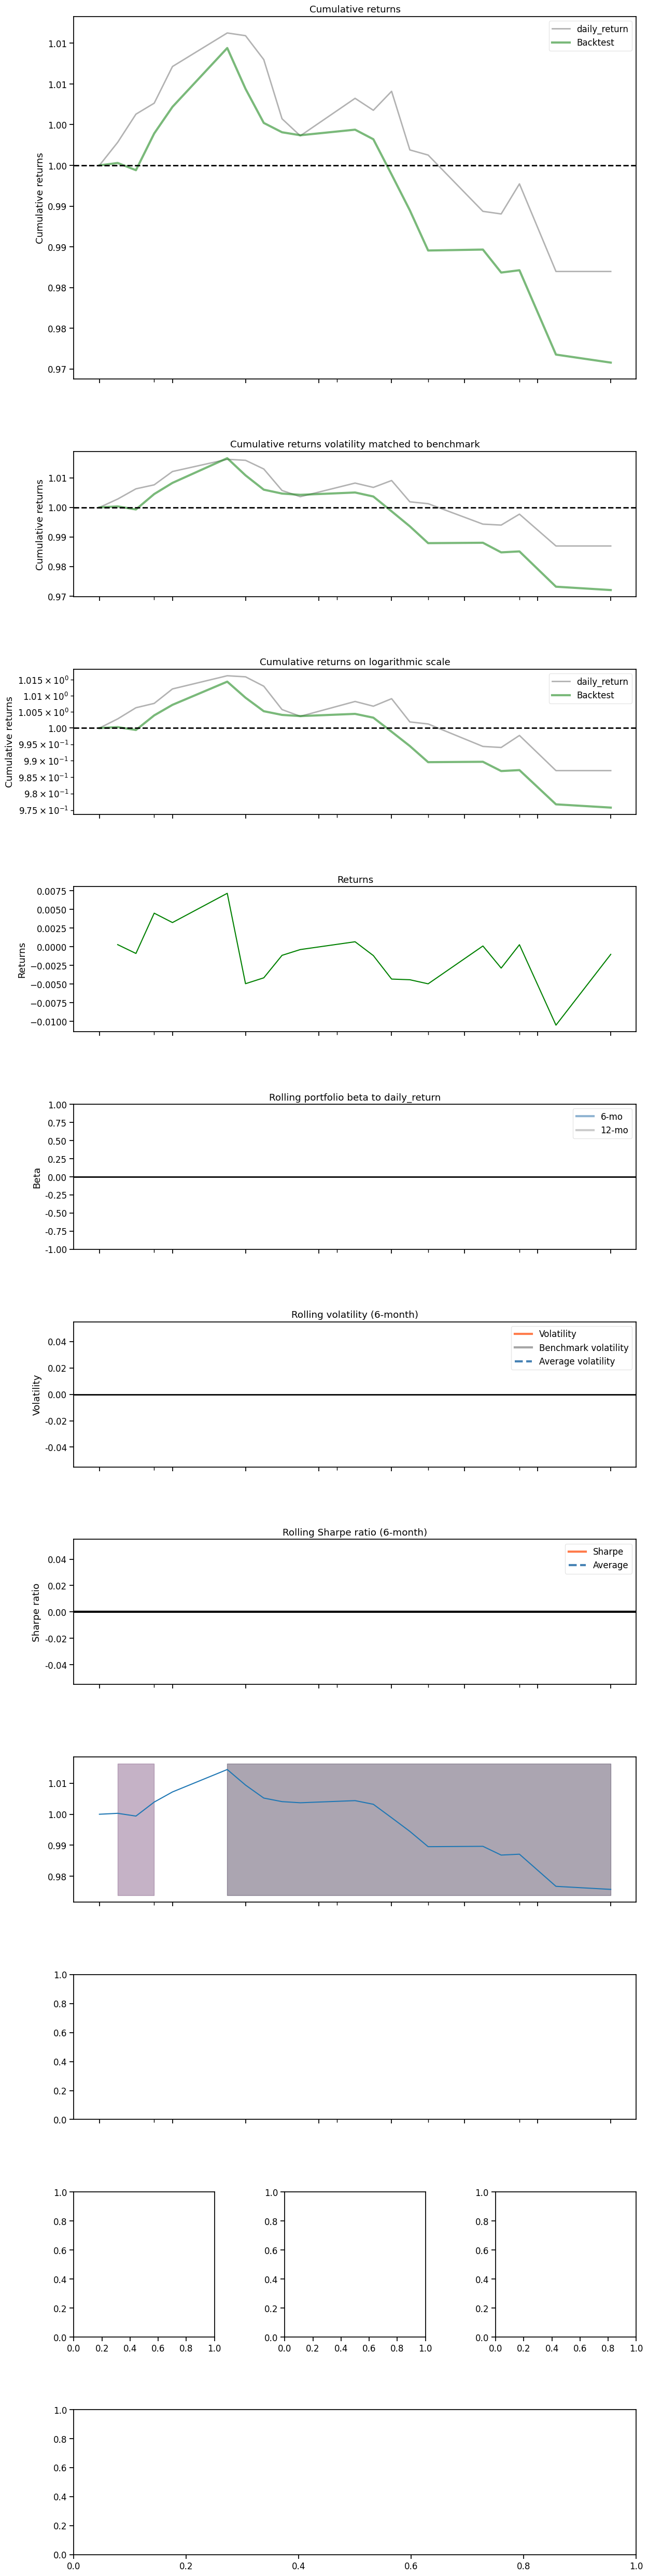

In [36]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])

In [30]:
!pip install git+https://github.com/quantopian/pyfolio

  Cloning https://github.com/quantopian/pyfolio to /private/var/folders/dv/ly5hp_ms3bd9753868lg6c5w0000gn/T/pip-req-build-k_z7aszg
  Running command git clone --filter=blob:none --quiet https://github.com/quantopian/pyfolio /private/var/folders/dv/ly5hp_ms3bd9753868lg6c5w0000gn/T/pip-req-build-k_z7aszg
  Resolved https://github.com/quantopian/pyfolio to commit 4b901f6d73aa02ceb6d04b7d83502e5c6f2e81aa
  Preparing metadata (setup.py) ... done
  Created wheel for pyfolio: filename=pyfolio-0.9.2+75.g4b901f6-py3-none-any.whl size=75753 sha256=e239efaaf245fc8015ea2ff064c49865aa950b2688e94d9e04db2816e77e32e3
  Stored in directory: /private/var/folders/dv/ly5hp_ms3bd9753868lg6c5w0000gn/T/pip-ephem-wheel-cache-08zkxu1_/wheels/25/2f/dd/558b6be9405213c9f6fdb1c5a062028a4da70862268f4116e6
Successfully built pyfolio

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
